In [1]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

In [2]:
! chmod 600 ~/.kaggle/kaggle.json


In [24]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
!kaggle datasets download -d tourist55/alzheimers-dataset-4-class-of-images

100% 34.0M/34.1M [00:03<00:00, 17.0MB/s]
100% 34.1M/34.1M [00:03<00:00, 9.62MB/s]


In [9]:
import zipfile
zip_ref=zipfile.ZipFile("/content/alzheimers-dataset-4-class-of-images.zip","r")
zip_ref.extractall('/content')
zip_ref.close();

In [5]:

!pip install split_folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
import splitfolders
!pip install keras-tuner --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 135 kB 30.1 MB/s 
     |████████████████████████████████| 1.6 MB 47.2 MB/s 


In [7]:
import numpy as np 
import pandas as pd 
import time
import itertools

import os
import os.path
from   os import path
import shutil

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import tensorflow as tf
import keras_tuner as kt
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras import backend, models, layers, Sequential
from tensorflow.keras.layers import Input, Concatenate, Dense, Dropout, Flatten, Add
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import InceptionV3


In [8]:
from skimage import io
import matplotlib.pyplot as plt
import tensorflow.keras.preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator 

In [10]:
FOLDERS     = ['train','val','test']
DIR_INPUT   = '/content/Alzheimer_s Dataset'
DIR_WORK    = './'
DIR_MODELS  = os.path.join(DIR_WORK,'models')
DIR_TRAIN   = os.path.join(DIR_WORK,'train')
DIR_VAL     = os.path.join(DIR_WORK,'val')
DIR_TEST    = os.path.join(DIR_WORK,'test')
CLASS_LIST  = ['MildDememted','ModerateDemented','NonDememted','VeryMildDemented']

SEED        = 1999
tf.random.set_seed(SEED)
np.random.seed(SEED)

In [11]:
def create_dir(dir_path,folder,verbose=True):
    msg = ""
    folder_path = os.path.join(dir_path,folder)
    if not path.exists(folder_path):
        try:
            os.mkdir(folder_path)
            msg = folder_path + ' created'
        except OSError as err:
            print('Error creating folder:{} with error:{}'.format(folder_path,err))
    if verbose:
        print(msg)
    return folder_path
create_dir(DIR_WORK,'models',True)

./models created


'./models'

In [12]:
def resample_train_val_images(input_dir,working_dir,seed=SEED,split = (0.80,0.20)):
    dir_test   = os.path.join(input_dir,'test')
    dir_train  = os.path.join(input_dir,'train')
    for folder in FOLDERS:
        if path.exists(os.path.join(working_dir,folder)):
            shutil.rmtree(os.path.join(working_dir,folder))
            
    splitfolders.ratio(dir_train, working_dir, seed=seed, ratio=split)
    shutil.copytree(dir_test, os.path.join(working_dir,'test'))
    
resample_train_val_images(DIR_INPUT,DIR_WORK)

Copying files: 5121 files [00:00, 7189.41 files/s]


In [13]:
IMG_SIZE = [176,208]
BATCH_SIZE = 32

train_images = ImageDataGenerator(rescale  = 1./255)
val_images   = ImageDataGenerator(rescale  = 1./255)
test_images  = ImageDataGenerator(rescale  = 1./255)


train_gen =train_images.flow_from_directory(
    DIR_TRAIN,
    target_size = IMG_SIZE,
    batch_size  = BATCH_SIZE,
    class_mode  = 'categorical',
    color_mode  = 'rgb',        
    seed        = SEED 
)

val_gen = val_images.flow_from_directory(
    DIR_VAL,
    target_size = IMG_SIZE,
    batch_size  = BATCH_SIZE,
    class_mode  = 'categorical',
    color_mode  = 'rgb',        
    seed        = SEED
)

test_gen = test_images.flow_from_directory(
    DIR_TEST,
    target_size = IMG_SIZE,
    batch_size  = BATCH_SIZE,
    class_mode  = 'categorical',
    color_mode  = 'rgb',         
    seed        = SEED,
    shuffle     = False
)


Found 4095 images belonging to 4 classes.
Found 1026 images belonging to 4 classes.
Found 1279 images belonging to 4 classes.


In [14]:
def freeze_layers(base,conv_num="conv5",block_num=1,max_block_num=16,trainable_layers='some'):

    if trainable_layers=='none':
        base.trainable = False
        print("No Layers Trainable: Using Base Model Weights")
    if trainable_layers=='all':
        base.trainable =True
        print("All Layers Trainable: Base Model will be fully trained")
    
    if trainable_layers=='some':
        
        print("Some Layers of the Model will be Trainable:")
        base.trainable = False
        print('layer','\t\t\t','trainable')
        for block in range(block_num,max_block_num+1):
            for layer in conv_base.layers:
                if block>=block_num:
                    if conv_num +"_block"+str(block) in layer.name:
                        layer.trainable = True
                        print(layer.name,'\t',layer.trainable)
                    
                    

In [15]:
def build_transfer_model(conv_base,dropout,dense_node,learn_rate,metric):
    backend.clear_session()
    model = Sequential()
    model.add(conv_base)
    model.add(Dropout(dropout))
    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dense(dense_node,activation='relu'))
    model.add(Dense(4,activation='softmax'))
    model.compile(
        optimizer = tensorflow.keras.optimizers.Adam(lr=learn_rate),
        loss      = 'categorical_crossentropy', 
        metrics   = metric ) 
    model.summary()
    return model

In [16]:
EPOCHS        = 25
early_stoping = EarlyStopping(monitor = 'val_auc',patience = 5,restore_best_weights=True, verbose=1)
callbacks     = [early_stoping]
metrics       = [tf.keras.metrics.AUC(name='auc')]

In [17]:
conv_base = InceptionV3(weights = 'imagenet', include_top = False, input_shape = (*IMG_SIZE, 3))
freeze_layers(conv_base,trainable_layers='none')
model = build_transfer_model(conv_base,dropout=0.4,dense_node =512,learn_rate=0.001,metric=metrics)
tic = time.perf_counter()
history = model.fit(
    train_gen,
    epochs           = EPOCHS,
    validation_data  = val_gen,
    verbose          = 2,
   # callbacks        = callbacks  
)



87910968/87910968 [==============================] - 7s 0us/step
No Layers Trainable: Using Base Model Weights
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 4, 5, 2048)        21802784  
                                                                 
 dropout (Dropout)           (None, 4, 5, 2048)        0         
                                                                 
 batch_normalization (BatchN  (None, 4, 5, 2048)       8192      
 ormalization)                                                   
                                                                 
 flatten (Flatten)           (None, 40960)             0         
                                                                 
 dense (Dense)               (None, 512)               20972032  
                                                                 
 dense_1 (D

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/25
128/128 - 26s - loss: 1.8823 - auc: 0.8145 - val_loss: 0.7368 - val_auc: 0.9053 - 26s/epoch - 201ms/step
Epoch 2/25
128/128 - 9s - loss: 0.6846 - auc: 0.9139 - val_loss: 0.7915 - val_auc: 0.8818 - 9s/epoch - 72ms/step
Epoch 3/25
128/128 - 9s - loss: 0.5046 - auc: 0.9548 - val_loss: 0.5505 - val_auc: 0.9470 - 9s/epoch - 73ms/step
Epoch 4/25
128/128 - 9s - loss: 0.3784 - auc: 0.9742 - val_loss: 0.4830 - val_auc: 0.9580 - 9s/epoch - 73ms/step
Epoch 5/25
128/128 - 10s - loss: 0.2537 - auc: 0.9887 - val_loss: 0.4324 - val_auc: 0.9678 - 10s/epoch - 76ms/step
Epoch 6/25
128/128 - 10s - loss: 0.1965 - auc: 0.9928 - val_loss: 0.4538 - val_auc: 0.9652 - 10s/epoch - 75ms/step
Epoch 7/25
128/128 - 10s - loss: 0.1372 - auc: 0.9965 - val_loss: 0.3406 - val_auc: 0.9796 - 10s/epoch - 75ms/step
Epoch 8/25
128/128 - 10s - loss: 0.1134 - auc: 0.9973 - val_loss: 0.3831 - val_auc: 0.9748 - 10s/epoch - 75ms/step
Epoch 9/25
128/128 - 11s - loss: 0.1080 - auc: 0.9972 - val_loss: 0.3237 - val_auc: 0

In [18]:
y_prob = model.predict(test_gen)
y_pred = y_prob.argmax(axis=-1)

y_actual = test_gen.classes


40/40 [==============================] - 4s 59ms/step



 Model AUC on Test Data:83.0%
------------------------------
              precision    recall  f1-score   support

        mild       0.66      0.22      0.33       179
    moderate       1.00      0.08      0.15        12
      normal       0.80      0.61      0.69       640
   very-mild       0.50      0.81      0.62       448

    accuracy                           0.62      1279
   macro avg       0.74      0.43      0.45      1279
weighted avg       0.68      0.62      0.61      1279



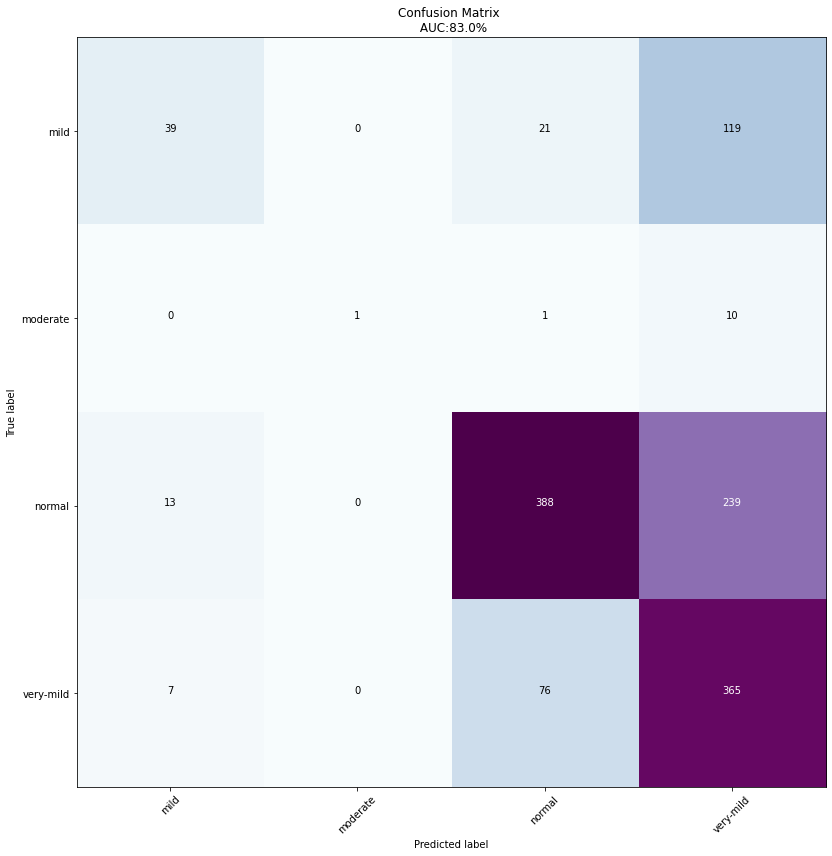

In [19]:
def plot_training_metrics(train_hist,model,test_gen,y_actual,y_pred,classes):

    test_loss, test_metric = model.evaluate(test_gen,verbose = False)
    results       = round(test_metric,2)*100 
    results_title ="\n Model AUC on Test Data:{}%".format(results)
    print(results_title.format(results))
    print(len(results_title) * "-")
    
    print(classification_report(y_actual, y_pred, target_names=classes))

    history_dict    = train_hist.history
    loss_values     = history_dict['loss']
    val_loss_values = history_dict['val_loss']
    auc_values      = history_dict['auc']
    val_auc_values  = history_dict['val_auc']
    epochs          = range(1, len(history_dict['auc']) + 1)

    max_auc = np.max(val_auc_values)
    min_loss = np.min(val_loss_values)
    plt.subplots(figsize=(12,12))
    cm = confusion_matrix(y_actual, y_pred)

    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.BuPu)
    plt.title("Confusion Matrix \n AUC:{}%".format(results))
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    threshold = cm.max() / 2.
    for r, c in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(c, r, format(cm[r, c], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[r, c] > threshold else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()
plot_training_metrics(history,model,test_gen,y_actual,y_pred,['mild','moderate','normal','very-mild'])

In [27]:
model.save("/content/gdrive/MyDrive/Azymer_dieases_detection/models1/model.h5")

In [25]:
imported = tf.saved_model.load('./models/base_model')

OSError: ignored

In [22]:
y_prob = model.predict(test_gen)
y_pred = y_prob.argmax(axis=-1)

y_actual = test_gen.classes

40/40 [==============================] - 2s 59ms/step


In [23]:
for i in range(0,10):
    print('Predicted Class:  '+CLASS_LIST[y_pred[i]]+'                   Actual Class:  ' + CLASS_LIST[y_actual[i]])

Predicted Class:  MildDememted                   Actual Class:  MildDememted
Predicted Class:  VeryMildDemented                   Actual Class:  MildDememted
Predicted Class:  MildDememted                   Actual Class:  MildDememted
Predicted Class:  VeryMildDemented                   Actual Class:  MildDememted
Predicted Class:  VeryMildDemented                   Actual Class:  MildDememted
Predicted Class:  VeryMildDemented                   Actual Class:  MildDememted
Predicted Class:  VeryMildDemented                   Actual Class:  MildDememted
Predicted Class:  VeryMildDemented                   Actual Class:  MildDememted
Predicted Class:  MildDememted                   Actual Class:  MildDememted
Predicted Class:  MildDememted                   Actual Class:  MildDememted


In [ ]:
from google.colab import drive
drive.mount('/content/drive')